# 0.0. IMPORTS

In [89]:
import pandas as pd
import numpy as np


In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from inflection import underscore

## 0.1. Helper Functions

## 0.2. Loading Data

!cd  && forfiles

In [3]:
df_sales_raw = pd.read_csv('../../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../../data/store.csv')

# merging --> key column = Store
df_raw = df_sales_raw.merge(df_store_raw, on='Store')

# 1.0. DATA DESCRIPTION

In [4]:
df01 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
# lower and separating by _
df01.columns = df_raw.columns.to_series().apply(lambda x: underscore(x))

## 1.2. Data Dimensions

In [6]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df01.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
801193,879,1,2013-11-25,2732,301,1,0,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
153472,170,4,2015-02-19,5925,594,1,1,0,0,a,a,1070.0,5.0,2015.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
691800,760,2,2014-07-22,7045,1281,1,0,0,1,a,a,560.0,1.0,2011.0,0,NaN,NaN,NaN


In [8]:
df01.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df01['date'] = pd.to_datetime(df01['date'])

## 1.4. Check NA

In [65]:
df01.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
sale_month                      0
is_promo                        0
dtype: int64

## 1.5. Fillout NA's

In [50]:
#competition_distance --> fill with a really big distante --> implies --> no competition
df01['competition_distance'].fillna(max(df01['competition_distance']) * 3,
                                    inplace=True)

#### The next 4 "since" attributes --> Filling the respective label ( month, year) of the sale date
#### Because if since month = sale month --> the difference will be 0
#competition_open_since_month --> fill with the month of the sale
df01['competition_open_since_month'].fillna(
    df01.loc[df01['competition_open_since_month'].isna(), 'date'].dt.month,
    inplace=True)

#competition_open_since_year --> fill with the year of the sale
df01['competition_open_since_year'].fillna(
    df01.loc[df01['competition_open_since_year'].isna(), 'date'].dt.year,
    inplace=True)

#promo2_since_week --> fill with the week of the sale
df01['promo2_since_week'].fillna(df01.loc[df01['promo2_since_week'].isna(),
                                          'date'].dt.isocalendar().week,
                                 inplace=True)

#promo2_since_year --> fill with the year of the sale
df01['promo2_since_year'].fillna(df01.loc[df01['promo2_since_year'].isna(),
                                          'date'].dt.year,
                                 inplace=True)

#promo_interval
df01['promo_interval'] = df01['promo_interval'].str.replace(
    'Sept', 'Sep')  # en_US format
df01['promo_interval'].fillna(0, inplace=True)  # there's no promo_interval

#df01['sale_month'] = df01['date'].dt.strftime('%b') --> deletar
# creating a column to know if the sale is in a promo month
df01['is_promo'] = df01[['promo_interval','date']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1
    if x['date'].dt.strftime('%b') in x['promo_interval'] else 0,
    axis=1)

C:\Users\Miguel\AppData\Local\Temp/ipykernel_12880/3545456638.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df01['promo2_since_week'].fillna(df01.loc[df01['promo2_since_week'].isna(),


## 1.6. Verifying Types

In [64]:
df01.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
sale_month                              object
is_promo                                 int64
dtype: object

In [63]:
df01['competition_open_since_month'] = df01['competition_open_since_month'].astype('int64')
df01['competition_open_since_year'] = df01['competition_open_since_year'].astype('int64')

df01['promo2_since_week'] = df01['promo2_since_week'].astype('int64')
df01['promo2_since_year'] = df01['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics

In [72]:
num_attributes = df01.select_dtypes(include=['int64','float64'])
cat_attributes = df01.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes

In [94]:
m1 = pd.DataFrame()
# Central tendency - mean, median
m1['mean'] = num_attributes.apply(np.mean)
m1['median'] =  num_attributes.apply(np.median)
# Dispersion - str, min, max, range, skew, kurtosis
m1['std'] = num_attributes.apply(np.std)
m1['min'] = num_attributes.apply(min)
m1['max'] = num_attributes.apply(max)
m1['range'] = num_attributes.apply(lambda x: x.max() - x.min())
m1['skew'] = num_attributes.apply(lambda x: x.skew())
m1['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

# just realocating columns
metrics = m1[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

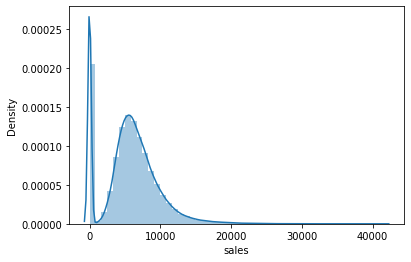

In [93]:
sns.distplot(df01['sales'])

### 1.7.1. Categorical Attributes

In [98]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
sale_month        12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

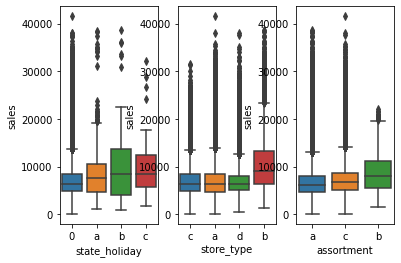

In [115]:
aux1 = df01.loc[(df01['state_holiday'] != 0) & (df01['sales'] >0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)